## Imports

In [390]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

## Data load

In [391]:
df = pd.read_csv("data.csv")

In [392]:
df

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2024,202401,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2024,202402,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2024,202403,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2024,202404,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2024,202405,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2249,Verkehrsunfälle,Verletzte und Getötete,2000,200008,647.0,NaN,-13.04,NaN,584.0
2250,Verkehrsunfälle,Verletzte und Getötete,2000,200009,675.0,NaN,4.33,NaN,594.0
2251,Verkehrsunfälle,Verletzte und Getötete,2000,200010,615.0,NaN,-8.89,NaN,596.0
2252,Verkehrsunfälle,Verletzte und Getötete,2000,200011,578.0,NaN,-6.02,NaN,594.0


## Analysis

In [393]:
df["AUSPRAEGUNG"].unique()

array(['insgesamt', 'Verletzte und Getötete', 'mit Personenschäden'],
      dtype=object)

In [394]:
df["MONATSZAHL"].unique()

array(['Alkoholunfälle', 'Fluchtunfälle', 'Verkehrsunfälle'], dtype=object)

In [395]:
df_cat = df[(df["AUSPRAEGUNG"] == "insgesamt") & (df["MONAT"] == "Summe")]

In [396]:
df_cat

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
24,Alkoholunfälle,insgesamt,2022,Summe,493.0,383.0,NaN,28.72,NaN
37,Alkoholunfälle,insgesamt,2021,Summe,383.0,430.0,NaN,-10.93,NaN
50,Alkoholunfälle,insgesamt,2020,Summe,430.0,434.0,NaN,-0.92,NaN
63,Alkoholunfälle,insgesamt,2019,Summe,434.0,398.0,NaN,9.05,NaN
76,Alkoholunfälle,insgesamt,2018,Summe,398.0,409.0,NaN,-2.69,NaN
...,...,...,...,...,...,...,...,...,...
1533,Verkehrsunfälle,insgesamt,2005,Summe,40723.0,40064.0,NaN,1.64,NaN
1546,Verkehrsunfälle,insgesamt,2004,Summe,40064.0,38635.0,NaN,3.70,NaN
1559,Verkehrsunfälle,insgesamt,2003,Summe,38635.0,40608.0,NaN,-4.86,NaN
1572,Verkehrsunfälle,insgesamt,2002,Summe,40608.0,45713.0,NaN,-11.17,NaN


In [397]:
# calculating sum for the months of 2001, as these figures are not in the dataset
df[(df["AUSPRAEGUNG"] == "insgesamt") & (df["JAHR"] == 2000)][["MONATSZAHL", "AUSPRAEGUNG", "WERT"]].groupby("MONATSZAHL").sum("WERT")

,WERT
MONATSZAHL,
Alkoholunfälle,934.0
Fluchtunfälle,11467.0
Verkehrsunfälle,44494.0


In [398]:
new_rows = pd.DataFrame({'MONATSZAHL': ['Alkoholunfälle', "Fluchtunfälle", "Verkehrsunfälle"], 'WERT': [934.0, 11467.0, 44494.0
], "JAHR": [2000, 2000, 2000]})

In [399]:
new_rows

,MONATSZAHL,WERT,JAHR
0,Alkoholunfälle,934.0,2000
1,Fluchtunfälle,11467.0,2000
2,Verkehrsunfälle,44494.0,2000


In [400]:
df_cat = pd.concat([df_cat, new_rows], ignore_index=True)

In [401]:
df_cat

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2022,Summe,493.0,383.0,NaN,28.72,NaN
1,Alkoholunfälle,insgesamt,2021,Summe,383.0,430.0,NaN,-10.93,NaN
2,Alkoholunfälle,insgesamt,2020,Summe,430.0,434.0,NaN,-0.92,NaN
3,Alkoholunfälle,insgesamt,2019,Summe,434.0,398.0,NaN,9.05,NaN
4,Alkoholunfälle,insgesamt,2018,Summe,398.0,409.0,NaN,-2.69,NaN
...,...,...,...,...,...,...,...,...,...
64,Verkehrsunfälle,insgesamt,2002,Summe,40608.0,45713.0,NaN,-11.17,NaN
65,Verkehrsunfälle,insgesamt,2001,Summe,45713.0,44494.0,NaN,2.74,NaN
66,Alkoholunfälle,NaN,2000,NaN,934.0,NaN,NaN,NaN,NaN
67,Fluchtunfälle,NaN,2000,NaN,11467.0,NaN,NaN,NaN,NaN


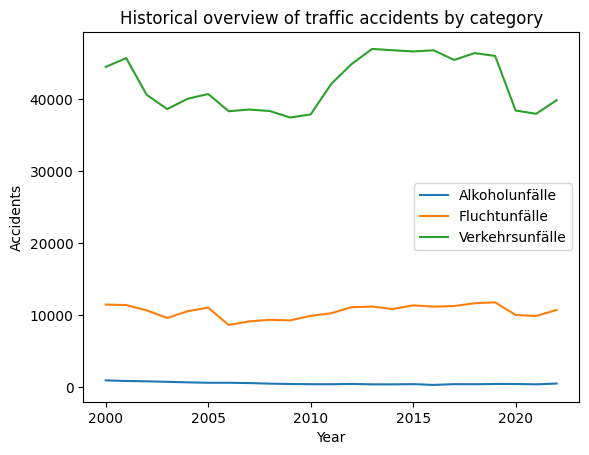

In [402]:
for cat in df["MONATSZAHL"].unique():
    df_tmp = df_cat[df_cat["MONATSZAHL"] == cat]
    plt.plot(df_tmp["JAHR"], df_tmp["WERT"], label=cat)


plt.xlabel("Year")
plt.ylabel("Accidents")
plt.xticks([2000, 2005, 2010, 2015, 2020])
plt.title("Historical overview of traffic accidents by category")
plt.legend()

plt.show()

## Linear Regression

In [403]:
df = df[(df["MONATSZAHL"] == "Alkoholunfälle") & (df["MONAT"] != "Summe") & (df["AUSPRAEGUNG"] == "insgesamt")]

In [404]:
df = df[["MONAT", "WERT", "VORJAHRESWERT"]]

In [405]:
df['month_date'] = pd.to_datetime(df['MONAT'].astype(str), format='%Y%m')

In [406]:
df = df.sort_values(by='month_date', ascending=True).reset_index(drop=True)

In [407]:
df['LAG_1'] = df['WERT'].shift(1)
df['LAG_2'] = df['WERT'].shift(2)
df['LAG_3'] = df['WERT'].shift(3)

In [408]:
df = df.dropna()

In [409]:
df

,MONAT,WERT,VORJAHRESWERT,month_date,LAG_1,LAG_2,LAG_3
12,200101,66.0,78.0,2001-01-01,85.0,71.0,83.0
13,200102,49.0,53.0,2001-02-01,66.0,85.0,71.0
14,200103,63.0,73.0,2001-03-01,49.0,66.0,85.0
15,200104,68.0,78.0,2001-04-01,63.0,49.0,66.0
16,200105,85.0,96.0,2001-05-01,68.0,63.0,49.0
...,...,...,...,...,...,...,...
271,202208,44.0,46.0,2022-08-01,54.0,60.0,57.0
272,202209,56.0,54.0,2022-09-01,44.0,54.0,60.0
273,202210,49.0,43.0,2022-10-01,56.0,44.0,54.0
274,202211,28.0,33.0,2022-11-01,49.0,56.0,44.0


In [410]:
# using the precomputed lagged variable from the original dataset
X = df[["LAG_1", "LAG_2", "LAG_3", "VORJAHRESWERT"]]
y = df["WERT"]

In [411]:
# up to 2020 is training data, afterwards is test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=12*20, shuffle=False)


In [412]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [413]:
y_pred = model.predict(X_test)

In [414]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 9.92


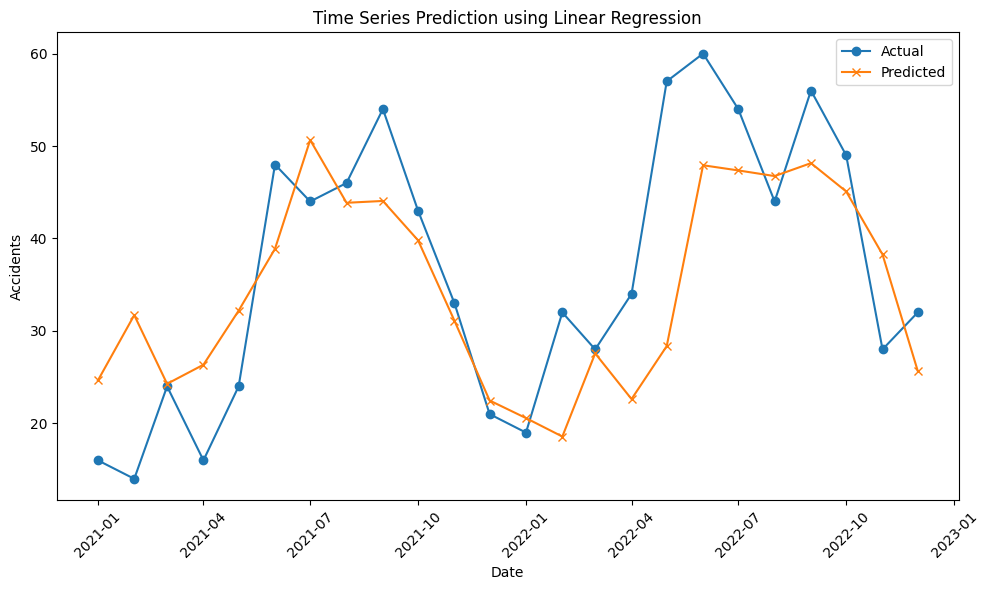

In [415]:
plt.figure(figsize=(10, 6))
plt.plot(df['month_date'][-len(y_test):], y_test, label='Actual', marker='o')
plt.plot(df['month_date'][-len(y_test):], y_pred, label='Predicted', marker='x')
plt.xlabel('Date')
plt.ylabel('Accidents')
plt.title('Time Series Prediction using Linear Regression')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [416]:
model.predict([[13.0, 23.0, 34.0, 28]])

/Users/ivanahacajova/Documents/DPS/DPS-AI-Challenge/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([24.63975715])

### Save model

In [417]:
with open('model-lr.pkl','wb') as f:
    pickle.dump(model,f)

## ARIMA

In [418]:
data = pd.Series(list(df["WERT"][:12*20]), 
                 index=df["month_date"][:12*20])

data

month_date
2001-01-01    66.0
2001-02-01    49.0
2001-03-01    63.0
2001-04-01    68.0
2001-05-01    85.0
              ... 
2020-08-01    46.0
2020-09-01    46.0
2020-10-01    34.0
2020-11-01    23.0
2020-12-01    13.0
Length: 240, dtype: float64

In [419]:
model = ARIMA(data, order=(3, 1, 1))
model_fit = model.fit()

/Users/ivanahacajova/Documents/DPS/DPS-AI-Challenge/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ivanahacajova/Documents/DPS/DPS-AI-Challenge/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ivanahacajova/Documents/DPS/DPS-AI-Challenge/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [420]:
forecast = model_fit.forecast(steps=24)

In [421]:
print(forecast)

2021-01-01    17.341837
2021-02-01    16.773255
2021-03-01    16.271511
2021-04-01    16.798197
2021-05-01    16.460132
2021-06-01    16.641917
2021-07-01    16.552652
2021-08-01    16.594260
2021-09-01    16.575451
2021-10-01    16.583806
2021-11-01    16.580129
2021-12-01    16.581741
2022-01-01    16.581035
2022-02-01    16.581344
2022-03-01    16.581209
2022-04-01    16.581268
2022-05-01    16.581242
2022-06-01    16.581254
2022-07-01    16.581248
2022-08-01    16.581251
2022-09-01    16.581250
2022-10-01    16.581250
2022-11-01    16.581250
2022-12-01    16.581250
Freq: MS, Name: predicted_mean, dtype: float64


In [422]:
df["WERT"][12*20:]

252    16.0
253    14.0
254    24.0
255    16.0
256    24.0
257    48.0
258    44.0
259    46.0
260    54.0
261    43.0
262    33.0
263    21.0
264    19.0
265    32.0
266    28.0
267    34.0
268    57.0
269    60.0
270    54.0
271    44.0
272    56.0
273    49.0
274    28.0
275    32.0
Name: WERT, dtype: float64

In [423]:
rmse = np.sqrt(mean_squared_error(df["WERT"][12*20:], forecast))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 24.53


In [424]:
with open('model-arima.pkl','wb') as f:
    pickle.dump(model,f)

## LSTM

In [434]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X = scaler_X.fit_transform(df[["LAG_3", "LAG_2", "LAG_1"]])
y = scaler_y.fit_transform(df[["WERT"]])


In [435]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=12*20, shuffle=False)

In [436]:
len(X_train)

240

In [437]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(3, 1)))
model.add(Dense(1))  
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = model.fit(X_train[:180], y_train[:180], epochs=50, batch_size=16, validation_data=(X_train[180:], y_train[180:]), verbose=1)

Epoch 1/50


/Users/ivanahacajova/Documents/DPS/DPS-AI-Challenge/env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1381 - val_loss: 0.0442
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1201 - val_loss: 0.0262
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0722 - val_loss: 0.0136
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0431 - val_loss: 0.0096
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - val_loss: 0.0168
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0221 - val_loss: 0.0214
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0211 - val_loss: 0.0155
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0207 - val_loss: 0.0140
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0200 - val_loss: 0.0152
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 - val_loss: 0.0139
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215 - val_loss: 0.0148
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171 - val_loss: 0.0130

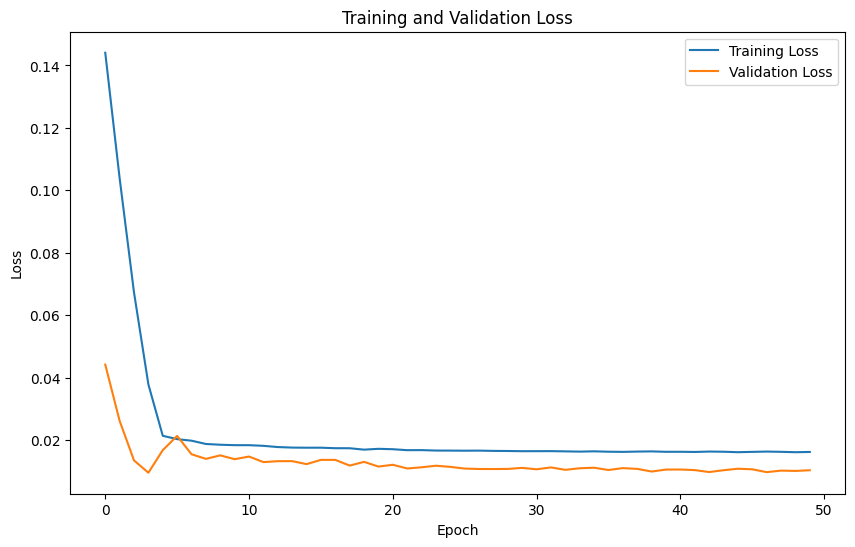

In [439]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [440]:
y_pred = model.predict(X_test)

y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


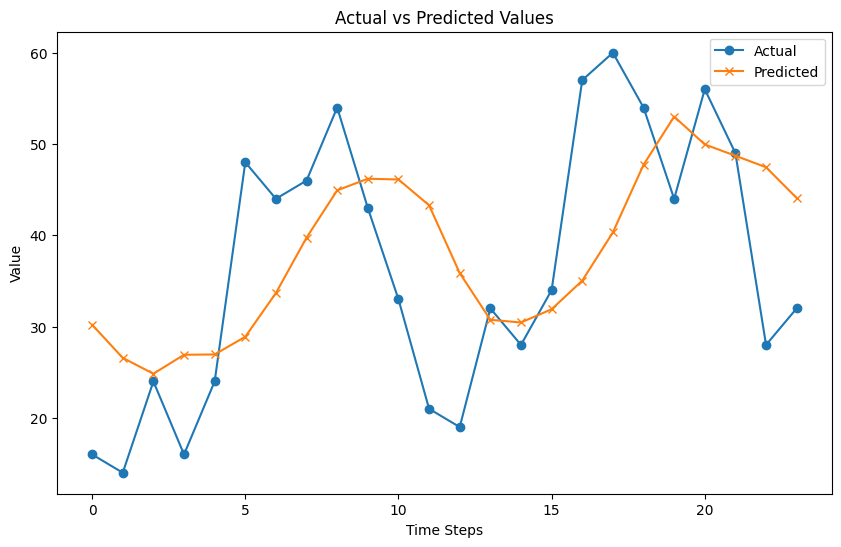

In [441]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='Actual', marker='o')
plt.plot(range(len(y_pred_rescaled)), y_pred_rescaled, label='Predicted', marker='x')
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

In [442]:
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 12.26


In [443]:
with open('model-lstm.pkl','wb') as f:
    pickle.dump(model,f)

## Conclusion

I tried 3 different models. The simple linear regression with 3 lagged variables yielded the best results on the test data (after 2020). ARIMA computes the lagged variables internally, managed to predict the next step (January 2021) with the best accuracy, but then converges to one value for the subsequent predictions. The LSTM produces smoother results, however the error is higher and also based on the training loss being higher than the validation loss, the network was not trained well, maybe due to the small training sample. 

In [445]:
df.to_csv('data_lagged.csv', index=False)